# Import Libraries

In [1]:
import pandas as pd
import requests

import yfinance as yf
from pandas_datareader import data as pdr

In [2]:
import datetime as dt

In [3]:
pd.options.display.max_columns=1000

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Folder Paths

In [4]:
raw_data_folder = "Data/raw"
presentation_data_folder = "Data/presentation"

<hr>

# Ingest & Transform Data 

## PBT Historical Asset Price

### Ingest from Yahoo Finance API

#### Get Current Date

In [5]:
present_date = dt.datetime.strftime(dt.datetime.now(), '%Y-%m-%d')
present_date

'2022-01-05'

In [6]:
yf.pdr_override()

# download dataframe
data = pdr.get_data_yahoo("PBT", start="1996-01-01", end=present_date)


[*********************100%***********************]  1 of 1 completed


### Transform - Select Columns

In [7]:
#resetting index to make date a column and only taking closing price and date
historical_close = data.reset_index()[['Date', 'Close']]
historical_close.head()
historical_close.to_csv(f"{presentation_data_folder}/pbt_asset_price/pbt asset price.csv", index = False)

,Date,Close
0,1996-01-02,3.125
1,1996-01-03,3.375
2,1996-01-04,3.500
3,1996-01-05,3.500
4,1996-01-08,3.625


<hr>


## Oil Price by Month - Excel Download
* Source URL: https://www.eia.gov/dnav/pet/hist/LeafHandler.ashx?n=PET&s=RWTC&f=M

### Ingest from Excel File Download

In [8]:
oilPricebyMonth = pd.read_csv(f"{raw_data_folder}/oil_prices/Cushing_OK_WTI_Spot_Price_FOB.csv", header = 4)

### Transform - Rename columns and Format Date Field

In [9]:
oilPricebyMonth.rename(columns = {oilPricebyMonth.columns[-1]: 'monthly_oil_price'}, inplace=True)

oilPricebyMonth.head()


,Month,monthly_oil_price
0,Nov 2021,79.15
1,Oct 2021,81.48
2,Sep 2021,71.65
3,Aug 2021,67.73
4,Jul 2021,72.49


In [10]:
testDate = oilPricebyMonth.iloc[0]['Month']
dt.datetime.strptime(testDate, '%b %Y')

oilPricebyMonth["Month"] = oilPricebyMonth['Month'].apply(lambda x: dt.datetime.strptime(x, '%b %Y'))

oilPricebyMonth["Adj Oil Price 1E-1"] = oilPricebyMonth['monthly_oil_price'] / 10
oilPricebyMonth.head()

datetime.datetime(2021, 11, 1, 0, 0)

,Month,monthly_oil_price,Adj Oil Price 1E-1
0,2021-11-01,79.15,7.915
1,2021-10-01,81.48,8.148
2,2021-09-01,71.65,7.165
3,2021-08-01,67.73,6.773
4,2021-07-01,72.49,7.249


In [11]:
oilPricebyMonth.to_csv(f"{presentation_data_folder}/oil_prices/oil price by month.csv", index = False)

## Gas Price by Month - Excel Download
* Source Url: https://www.eia.gov/dnav/ng/hist/rngwhhdm.htm

### Ingest from Excel File Download

In [12]:
gasPricebyMonth = pd.read_excel(f"{raw_data_folder}/gas_prices/RNGWHHDm.xls", sheet_name= 'Data 1', header = 2)

### Transform - Rename columns

In [13]:
gasPricebyMonth.rename(columns = {gasPricebyMonth.columns[-1]: 'monthly_gas_price'}, inplace=True)

gasPricebyMonth.head()
gasPricebyMonth.to_csv(f"{presentation_data_folder}/gas_prices/gas price by month.csv", index = False)

,Date,monthly_gas_price
0,1997-01-15,3.45
1,1997-02-15,2.15
2,1997-03-15,1.89
3,1997-04-15,2.03
4,1997-05-15,2.25


<hr>
<br>



## Historical Field Production

### Ingest historical production

In [14]:
historical_prod = pd.read_csv(f'{raw_data_folder}/historical_production/Historical Production.csv')

### Transform - Convert String Timestamp to Date and Adding Fields

In [15]:
historical_prod['Date'] = pd.to_datetime(historical_prod['Date'])

historical_prod['Mbbl/month'] = historical_prod['Oil']/1E3
historical_prod['Ten\'s of Thousand bbl /month (1E-4)'] = historical_prod['Oil']/1E4

historical_prod['MMcf/month'] = historical_prod['Gas']/1E3
historical_prod['Ten\'s of Thousand mcf /month (1E-4)'] = historical_prod['Gas']/1E4

In [16]:
historical_prod.to_csv(f'{presentation_data_folder}/historical_production/historical_production.csv', index = False)

<hr>
<br>

## Wells in Field

### Ingest Wells

In [17]:
wells = pd.read_csv(f'{raw_data_folder}/wells/Production Table.csv')

### Transform - Add Fields

In [18]:
wells["Total MMbbl"] = wells['Cum Oil']/1E6
wells["Total BCF"] = wells['Cum Gas']/1E6

In [19]:
wells.to_csv(f'{presentation_data_folder}/wells/wells.csv', index = False)

<hr>
<br>

## Permits

### Ingest Permits

In [20]:
permits = pd.read_csv(f'{raw_data_folder}/permits/Permits Table.csv')

### Transform - Group Similar Values in Well Status Field

In [21]:
def group_categories(value, similar_categories, target_category):
    '''
    similar_categories: list of values that wish to be grouped together
    target_category: value for similar values to be grouped to
    value: value in row of DataFrame
    '''
    if value in similar_categories:
        return target_category
    else:
        return value

In [22]:
vals_to_be_grouped = ['DUC', 'COMPLETED', 'INACTIVE', 'DRILLED']

In [23]:
permits['Well Status Grouped'] = permits['Well Status'].apply(lambda x: group_categories(x, vals_to_be_grouped, 'Drilled, Not Producing'))

In [24]:
permits['Well Status Grouped'].value_counts()

PERMITTED                 77
Drilled, Not Producing    68
ACTIVE                    34
UNKNOWN                   11
CANCELLED                  3
DRILLING                   2
P & A                      1
Name: Well Status Grouped, dtype: int64

In [25]:
permits.to_excel(f'{presentation_data_folder}/permits/permits.xlsx', index = False)

<hr>
<br>

# Combined Tables for Analysis

## Gross Revenue 

In [26]:
historical_prod.head(1)
oilPricebyMonth.head(1)
gasPricebyMonth.head(1)

,Date,Oil,Gas,Water,Well Count,Mbbl/month,Ten's of Thousand bbl /month (1E-4),MMcf/month,Ten's of Thousand mcf /month (1E-4)
0,1941-01-01,4684,0,16736,1,4.684,0.4684,0.0,0.0


,Month,monthly_oil_price,Adj Oil Price 1E-1
0,2021-11-01,79.15,7.915


,Date,monthly_gas_price
0,1997-01-15,3.45


### Transform - Create Field for Joining Tables

In [27]:
#creating field for joining 3 tables since dates resembling each month differ slightly
historical_prod['Date Key'] = historical_prod['Date'].apply(lambda x: dt.datetime.strftime(x, '%Y-%m'))
gasPricebyMonth['Date Key'] = gasPricebyMonth['Date'].apply(lambda x: dt.datetime.strftime(x, '%Y-%m'))
oilPricebyMonth['Date Key'] = oilPricebyMonth['Month'].apply(lambda x: dt.datetime.strftime(x, '%Y-%m'))

In [28]:
historical_prod.head(2)
oilPricebyMonth.head(2)
gasPricebyMonth.head(2)

,Date,Oil,Gas,Water,Well Count,Mbbl/month,Ten's of Thousand bbl /month (1E-4),MMcf/month,Ten's of Thousand mcf /month (1E-4),Date Key
0,1941-01-01,4684,0,16736,1,4.684,0.4684,0.0,0.0,1941-01
1,1941-02-01,5458,0,19502,1,5.458,0.5458,0.0,0.0,1941-02


,Month,monthly_oil_price,Adj Oil Price 1E-1,Date Key
0,2021-11-01,79.15,7.915,2021-11
1,2021-10-01,81.48,8.148,2021-10


,Date,monthly_gas_price,Date Key
0,1997-01-15,3.45,1997-01
1,1997-02-15,2.15,1997-02


### Perform Join and Clean Up Fields

In [29]:
#merging 3 tables together to get commodity pricing along side production. Then cleaning up by selecting only necessary columns
revenue = pd.merge(historical_prod, oilPricebyMonth.drop(columns = 'Month'), on = 'Date Key', how = 'inner') \
    .merge(gasPricebyMonth.drop(columns = 'Date'), on = 'Date Key', how = 'inner') \
    .drop(columns = 'Date Key') \
    .loc[:,['Date', 'Oil', 'Gas', 'monthly_oil_price', 'monthly_gas_price']]

### Calculate Revenue for Oil, Gas, and Total

In [30]:
revenue["Revenue Oil"] = revenue["Oil"] * revenue['monthly_oil_price']
revenue["Revenue Gas"] = revenue["Gas"] * revenue['monthly_gas_price']

revenue['Total Revenue'] = revenue["Revenue Oil"] + revenue["Revenue Gas"]

revenue['$M Total Revenue'] = round(revenue["Total Revenue"] / 1E6, 2)

revenue

,Date,Oil,Gas,monthly_oil_price,monthly_gas_price,Revenue Oil,Revenue Gas,Total Revenue,$M Total Revenue
0,1997-01-01,280995,1202974,25.13,3.45,7061404.35,4150260.30,11211664.65,11.21
1,1997-02-01,260744,1161835,22.18,2.15,5783301.92,2497945.25,8281247.17,8.28
2,1997-03-01,290928,1284172,20.97,1.89,6100760.16,2427085.08,8527845.24,8.53
3,1997-04-01,286429,1232001,19.70,2.03,5642651.30,2500962.03,8143613.33,8.14
4,1997-05-01,310124,1289414,20.82,2.25,6456781.68,2901181.50,9357963.18,9.36
...,...,...,...,...,...,...,...,...,...
293,2021-06-01,200332,914030,71.38,3.26,14299698.16,2979737.80,17279435.96,17.28
294,2021-07-01,220864,1002275,72.49,3.84,16010431.36,3848736.00,19859167.36,19.86
295,2021-08-01,206105,1023171,67.73,4.07,13959491.65,4164305.97,18123797.62,18.12
296,2021-09-01,203026,973874,71.65,5.16,14546812.90,5025189.84,19572002.74,19.57


In [31]:
revenue.to_csv(f'{presentation_data_folder}/revenue/revenue.csv', index = False)

## Creating Normalized / Scaled Revenue and Asset Price -  from 0 to 1

In [32]:
from sklearn import preprocessing

### Scaling Revenue

In [33]:
scalerRev = preprocessing.MinMaxScaler().fit(revenue.iloc[:,1:])

In [34]:
scaled_revenue_vals = scalerRev.transform(revenue.iloc[:,1:])

In [35]:
scaled_Revenue = pd.DataFrame(scaled_revenue_vals)
scaled_Revenue.insert(0, 'Date', revenue['Date'])
scaled_Revenue.columns = revenue.columns
scaled_Revenue

,Date,Oil,Gas,monthly_oil_price,monthly_gas_price,Revenue Oil,Revenue Gas,Total Revenue,$M Total Revenue
0,1997-01-01,0.722649,0.845847,0.112462,0.154368,0.233823,0.259824,0.244986,0.244840
1,1997-02-01,0.634258,0.790250,0.088387,0.044105,0.155704,0.109146,0.126395,0.126265
2,1997-03-01,0.766005,0.955581,0.078511,0.022053,0.175108,0.102684,0.136374,0.136382
3,1997-04-01,0.746367,0.885075,0.068147,0.033927,0.147108,0.109421,0.120825,0.120599
4,1997-05-01,0.849791,0.962665,0.077287,0.052587,0.196868,0.145918,0.169968,0.169972
...,...,...,...,...,...,...,...,...,...
293,2021-06-01,0.370574,0.455358,0.489921,0.138253,0.676233,0.153081,0.490545,0.490490
294,2021-07-01,0.460191,0.574615,0.498980,0.187447,0.780795,0.232327,0.594945,0.594901
295,2021-08-01,0.395771,0.602855,0.460132,0.206955,0.655440,0.261105,0.524716,0.524484
296,2021-09-01,0.382332,0.536233,0.492124,0.299406,0.691337,0.339611,0.583323,0.583165


In [36]:
for column in scaled_Revenue.columns[1:]:
    scaled_Revenue.rename(columns = {column: f'scaled_{column}'}, inplace=True)

In [37]:
scaled_Revenue.head(2)
scaled_Revenue.to_csv(f'{presentation_data_folder}/scaled_transforms/scaled_revenue_and_commodity.csv', index = False)

,Date,scaled_Oil,scaled_Gas,scaled_monthly_oil_price,scaled_monthly_gas_price,scaled_Revenue Oil,scaled_Revenue Gas,scaled_Total Revenue,scaled_$M Total Revenue
0,1997-01-01,0.722649,0.845847,0.112462,0.154368,0.233823,0.259824,0.244986,0.244840
1,1997-02-01,0.634258,0.790250,0.088387,0.044105,0.155704,0.109146,0.126395,0.126265


### Scaling Asset Price

In [38]:
scalerRev = preprocessing.MinMaxScaler().fit(historical_close.iloc[:,1:])

scaled_historical_close_vals = scalerRev.transform(historical_close.iloc[:,1:])

scaled_historical_close = pd.DataFrame(scaled_historical_close_vals)
scaled_historical_close.insert(0, 'Date', historical_close['Date'])
scaled_historical_close.columns = historical_close.columns
scaled_historical_close.head(2)

,Date,Close
0,1996-01-02,0.036942
1,1996-01-03,0.046819


#### Rename cols to Scaled 'x'

In [39]:
for column in scaled_historical_close.columns[1:]:
    scaled_historical_close.rename(columns = {column: f'scaled_{column}'}, inplace=True)

In [40]:
scaled_historical_close.head(2)
scaled_historical_close.to_csv(f'{presentation_data_folder}/scaled_transforms/scaled_asset_price.csv', index = False)

,Date,scaled_Close
0,1996-01-02,0.036942
1,1996-01-03,0.046819


In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

<Figure size 1080x504 with 0 Axes>

Text(0.5, 1.0, 'Revenue ($M) vs Year')

/Users/Mishaun_Bhakta/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Revenue ($M) vs Year'}, xlabel='Date', ylabel='$M Total Revenue'>

/Users/Mishaun_Bhakta/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Revenue ($M) vs Year'}, xlabel='Date', ylabel='$M Total Revenue'>

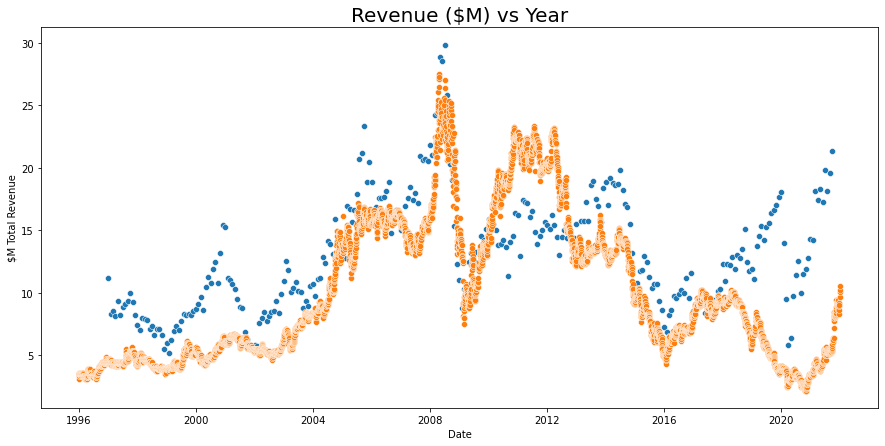

In [53]:
plt.figure(figsize=(15,7))

plt.title('Revenue ($M) vs Year', fontdict={"fontsize": 20})
sns.scatterplot(revenue['Date'], revenue['$M Total Revenue'], palette='rainbow')
sns.scatterplot(historical_close["Date"], historical_close['Close'])